In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os

# modify csv files to follow a certain distribution and keep only relevant columns

## MIMIC

In [2]:
path = r"C:\Users\rankl\Documents\uni\Thesis\Development\modelDesign_bias_CXR\data\MIMICCXR\patients - metadata - pathologies.csv"
pathologies_metadata = pd.read_csv(path)

### total distributions of front X-Rays

In [3]:
pa_ap_samples = pathologies_metadata.loc[pathologies_metadata['ViewPosition'].isin(['PA', 'AP'])]


In [4]:
count_subjects_df = pa_ap_samples.loc[:, ['subject_id','study_id', 'gender', 'dicom_id','split','ViewPosition',
            'Atelectasis',
            'Cardiomegaly',
            'Consolidation',
            'Edema',
            'Enlarged Cardiomediastinum',
            'Fracture',
            'Lung Lesion',
            'Lung Opacity',
            'No Finding',
            'Pleural Effusion',
            'Pleural Other',
            'Pneumonia',
            'Pneumothorax',
            'Support Devices' 
            ]]

In [5]:
len(count_subjects_df)

243149

In [6]:
# total number of females and males in the dataset by split
#count_subjects_df.groupby(['gender','split']).agg({'subject_id': 'nunique'})
# number of xRays by gender and split
#count_subjects_df.groupby(['gender','split']).agg({'dicom_id': 'nunique'})

In [7]:
labels = ['Atelectasis','Cardiomegaly','Consolidation','Edema','Enlarged Cardiomediastinum','Fracture','Lung Lesion','Lung Opacity','No Finding','Pleural Effusion','Pleural Other','Pneumonia','Pneumothorax','Support Devices']

In [8]:
diseases_incl = ['Atelectasis', 'Cardiomegaly', 'Lung Opacity', 'Edema' , 'Pleural Effusion','Support Devices']

### subset of ['Edema','Cardiomegaly','Support Devices','Atelectasis','Pleural Effusion',  'Lung Opacity']

In [9]:
#label_subset = labels

label_subset = ['Edema','Cardiomegaly','Atelectasis','Lung Opacity','Pleural Effusion','Support Devices']
#label_subset = ['Edema','Cardiomegaly','Atelectasis']
#label_subset = ['Edema','Support Devices','Cardiomegaly']
column_subset = ['subject_id','study_id', 'gender', 'dicom_id','split'] 
column_subset = column_subset + label_subset

data_subset = count_subjects_df.loc[:,column_subset]
test_validate = count_subjects_df.loc[count_subjects_df["split"] != "train",column_subset]
data_subset[label_subset] = data_subset[label_subset].applymap(lambda x: np.nan if x <= 0 else x)
data_subset.dropna(subset=label_subset, how='all', inplace=True)
data_subset[label_subset] = data_subset[label_subset].applymap(lambda x: 0 if np.isnan(x) else x)
#data_subset.to_csv('total_AP_PA_ds.csv', index=False)


In [10]:
data_subset_local = data_subset
data_subset_local = data_subset_local[data_subset_local['subject_id'].astype(str).str.startswith('10')]
#data_subset_local.to_csv('Ed_Sup_Ca_local.csv', index=False)

In [11]:
grouped_df = data_subset.groupby(['gender','split']).agg({
    'Edema': 'sum',
    'Cardiomegaly': 'sum',
    'Atelectasis': 'sum',
    'Lung Opacity': 'sum',
    'Pleural Effusion': 'sum',
    'Support Devices': 'sum',
    'dicom_id': 'count'
}).reset_index()

In [12]:
grouped_df.to_csv("grouping_split.csv", index=False)

# Aggregations

In [13]:
data = pd.read_csv(r"C:\Users\rankl\Documents\uni\Thesis\Development\modelDesign_bias_CXR\data\MIMICCXR\22030000.csv")
#len(data_subset)

In [14]:
def aggregate(df,labels, byGender):
    # Initialize an empty dictionary to store the aggregation functions
    aggregation_functions = {}

    # Iterate over the columns and add them to the aggregation functions dictionary
    for column in labels:
        aggregation_functions[column] = 'sum'
    if byGender:
        # Perform the dynamic aggregation
        result = df.groupby(['gender']).agg(aggregation_functions)
    else:
        result = pd.DataFrame(df.agg(aggregation_functions)).T

    return result
df_agg = aggregate(data_subset,label_subset, True)
df_agg

,Edema,Cardiomegaly,Atelectasis,Lung Opacity,Pleural Effusion,Support Devices
gender,,,,,,
F,13512.0,22071.0,20760.0,23861.0,25771.0,29935.0
M,15817.0,25598.0,28024.0,30881.0,31943.0,43344.0


# Label powerset

In [15]:
ids_array = [1, 3, 5, 10, 20, 40] #,80,160,320,640,1280,2560,5120,10240
data_subset["powerset"] = data_subset.apply(lambda x: sum(val * x[col] for val, col in zip(ids_array, label_subset)), axis=1)


In [16]:
np.unique(data_subset['powerset'])

array([ 1.,  3.,  4.,  5.,  6.,  8.,  9., 10., 11., 13., 14., 15., 16.,
       18., 19., 20., 21., 23., 24., 25., 26., 28., 29., 30., 31., 33.,
       34., 35., 36., 38., 39., 40., 41., 43., 44., 45., 46., 48., 49.,
       50., 51., 53., 54., 55., 56., 58., 59., 60., 61., 63., 64., 65.,
       66., 68., 69., 70., 71., 73., 74., 75., 76., 78., 79.])

In [17]:
#data_subset[1:20]

In [18]:
pwset_list = []
for set_id in np.unique(data_subset['powerset']):    
    # Specify the 'powerset' set_id for which you want to retrieve column names with value 1

    # Get the row corresponding to the first occurrence of set_id
  row = data_subset.loc[data_subset['powerset'] == set_id].iloc[0]

    # Filter the row to get the column names with value 1
  column_names = row[row == 1].index.tolist()

  combined_letters = [name[:2] for name in column_names if name != 'powerset']
  pwset_list.append(combined_letters)
  #print(set_id,combined_letters)

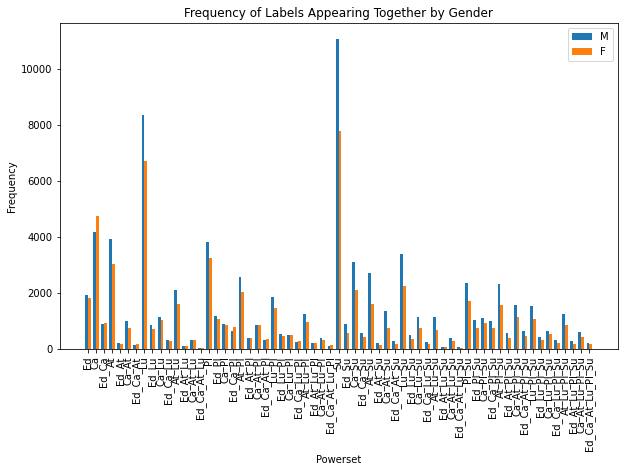

In [19]:
def plot_by_powerset(df):
    unique_values = np.unique(df['powerset'])

    # Calculate the value counts for 'M' and 'F' genders
    value_counts_m = df[df['gender'] == 'M']['powerset'].value_counts()
    value_counts_f = df[df['gender'] == 'F']['powerset'].value_counts()

    # Create an array to store the heights of the bars for 'M' and 'F'
    bar_heights_m = [value_counts_m[value] if value in value_counts_m else 0 for value in unique_values]
    bar_heights_f = [value_counts_f[value] if value in value_counts_f else 0 for value in unique_values]

    # Set the width of the bars
    bar_width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))

    # Set the x-axis ticks and corresponding labels
    x_ticks = np.arange(len(unique_values))
    x_ticks_strings = ['_'.join(sublist) for sublist in pwset_list] 
    plt.xticks(x_ticks, x_ticks_strings, rotation=90)



    # Create the bar chart for 'M'
    plt.bar(x_ticks - bar_width/2, bar_heights_m, width=bar_width, label='M')

    # Create the bar chart for 'F'
    plt.bar(x_ticks + bar_width/2, bar_heights_f, width=bar_width, label='F')

    # Set the labels and title
    plt.xlabel('Powerset')
    plt.ylabel('Frequency')
    plt.title('Frequency of Labels Appearing Together by Gender')

    # Add a legend
    plt.legend()

    # Show the plot
    plt.show()
plot_by_powerset(data_subset)

# Label density

In [20]:
def label_density_perLabel(df):
    labels_data = df[label_subset]
    labels_data.applymap(lambda x: np.nan if x <= 0 else x)
    labels_data.dropna( how='all', inplace=True)
    num_instances = labels_data.shape[0]

    # Count the total number of labels
    num_labels = np.sum(labels_data)

    # Calculate the label density
    label_density = num_labels / num_instances

    print("Label Density:", label_density)

label_density_perLabel(data_subset)


Label Density: Edema               0.193444
Cardiomegaly        0.314408
Atelectasis         0.321762
Lung Opacity        0.361059
Pleural Effusion    0.380662
Support Devices     0.483323
dtype: float64


C:\Users\rankl\AppData\Local\Temp\ipykernel_11956\3190376666.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels_data.dropna( how='all', inplace=True)


In [21]:
def label_density_perFormula(df):
    # we use the formula of Tsoumakas et al. in "A Review of Multi-Label Classification Methods"
    labels_data = df[label_subset]
    labels_data.applymap(lambda x: np.nan if x <= 0 else x)
    labels_data.dropna( how='all', inplace=True)

    D = len(labels_data)
    L = len(labels_data.columns)
    Y_i = labels_data.sum(axis=1)

    # Divide the sum of each row by the number of columns
    summation = Y_i.div(L)

    # Sum up the results for each row
    sum_of_results = summation.sum()
    
    label_density = sum_of_results / D
    # Print the sum of the results
    print(label_density)
label_density_perFormula(data_subset)

0.3424430300432016


C:\Users\rankl\AppData\Local\Temp\ipykernel_11956\1114476469.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels_data.dropna( how='all', inplace=True)


# Random oversampling

In [22]:
def oversampling_simple(df, limit):
    unique_values = np.unique(data_subset['powerset'])
    result_df = df.copy()
    for value in unique_values:
        value_counts = df[df['powerset'] == value].value_counts()

        if value_counts.size < limit:
            samp_to_select = limit - value_counts.size
            temp_df = df.iloc[np.random.choice(np.where(df['powerset']==value)[0],size=samp_to_select)]
            result_df = pd.concat([result_df, temp_df], ignore_index=True)

    return result_df

simple_oversampled_df = oversampling_simple(data_subset,5000)

In [23]:
def oversampling_gender(df,limit):
    unique_values = np.unique(df['powerset'])
    
    result_df = df.copy()
    gender_list = ['M','F']
    for value in unique_values:
# If the difference is greater than zero, it randomly selects a subset of rows from the selected rows to add to the result DataFrame `result_df`. 
# Finally, it concatenates the selected rows to the result DataFrame `result_df`. 
# This process is repeated for each unique powerset value in the input DataFrame `df`. 
# The result is an oversampled DataFrame with an equal number of rows for each unique powerset value and gender combination, up to the specified limit.
        for gender in gender_list:
            value_counts = df[(df['gender'] == gender) & (df['powerset'] == value)].value_counts()
            samp_to_select = limit - value_counts.size
            if samp_to_select < 0:
                continue
            temp_df = df.iloc[np.random.choice(np.where((df['powerset']==value) & (df['gender'] == gender))[0],size=samp_to_select)]
            result_df = pd.concat([result_df, temp_df], ignore_index=True)
    return result_df
thorough_ovs_df = oversampling_gender(data_subset, limit=9000)

In [24]:
#thorough_ovs_df.to_csv("Ed_Su_Ca_ovs_equal.csv", index=False)
#thorough_ovs_df = thorough_ovs_df.drop(columns="powerset")

## Validation of oversampling

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


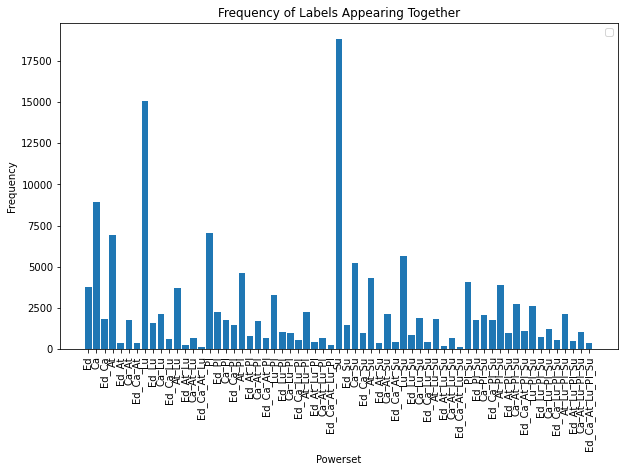

In [25]:
def plot_ovs_df(df):    
    unique_values = np.unique(df['powerset'])

    # Calculate the value counts for 'M' and 'F' genders
    value_counts = df['powerset'].value_counts()

    # Create an array to store the heights of the bars
    bar_heights = [value_counts[value] if value in value_counts else 0 for value in unique_values]

    fig, ax = plt.subplots(figsize=(10, 6))
    # Set the x-axis ticks and corresponding labels
    x_ticks = np.arange(len(unique_values))
    x_ticks_strings = ['_'.join(sublist) for sublist in pwset_list] 
    plt.xticks(x_ticks, x_ticks_strings, rotation=90)

    # Create the bar chart for 'M'
    plt.bar(x_ticks , bar_heights)

    # Set the labels and title
    plt.xlabel('Powerset')
    plt.ylabel('Frequency')
    plt.title('Frequency of Labels Appearing Together')

    # Add a legend
    plt.legend()

    # Show the plot
    plt.show()

plot_ovs_df(data_subset)

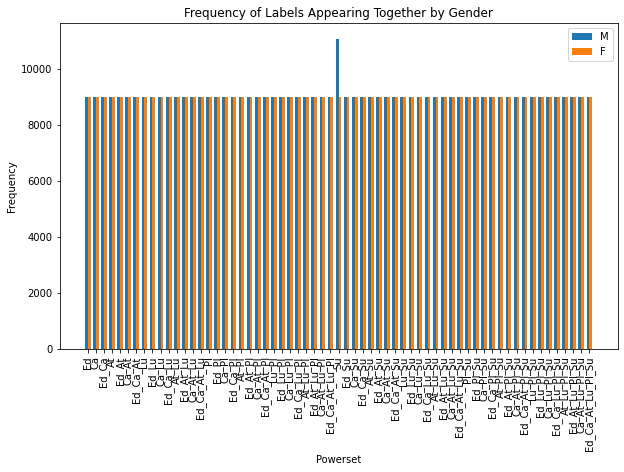

In [26]:
def plot_ovs_gender_df(df):
    unique_values = np.unique(df['powerset'])

    # Calculate the value counts for 'M' and 'F' genders
    value_counts_m = df[df['gender'] == 'M']['powerset'].value_counts()
    value_counts_f = df[df['gender'] == 'F']['powerset'].value_counts()

    # Create an array to store the heights of the bars for 'M' and 'F'
    bar_heights_m = [value_counts_m[value] if value in value_counts_m else 0 for value in unique_values]
    bar_heights_f = [value_counts_f[value] if value in value_counts_f else 0 for value in unique_values]

    # Set the width of the bars
    bar_width = 0.35
    fig, ax = plt.subplots(figsize=(10, 6))
    # Set the x-axis ticks and corresponding labels
    x_ticks = np.arange(len(unique_values))
    x_ticks_strings = ['_'.join(sublist) for sublist in pwset_list] 
    plt.xticks(x_ticks, x_ticks_strings, rotation=90)

    # Create the bar chart for 'M'
    plt.bar(x_ticks - bar_width/2, bar_heights_m, width=bar_width, label='M')

    # Create the bar chart for 'F'
    plt.bar(x_ticks + bar_width/2, bar_heights_f, width=bar_width, label='F')

    # Set the labels and title
    plt.xlabel('Powerset')
    plt.ylabel('Frequency')
    plt.title('Frequency of Labels Appearing Together by Gender')

    # Add a legend
    plt.legend()

    # Show the plot
    plt.show()

plot_ovs_gender_df(thorough_ovs_df)

In [27]:
equal_ovs = aggregate(thorough_ovs_df,label_subset,True)
equal_ovs
#equal_ovs.to_csv("equal_ovs.csv", index=True)

,Edema,Cardiomegaly,Atelectasis,Lung Opacity,Pleural Effusion,Support Devices
gender,,,,,,
F,288000.0,288000.0,288000.0,288000.0,288000.0,288000.0
M,288000.0,288000.0,288000.0,288000.0,288000.0,290076.0


In [28]:
label_density_perFormula(thorough_ovs_df)
label_density_perLabel(thorough_ovs_df)

C:\Users\rankl\AppData\Local\Temp\ipykernel_11956\1114476469.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels_data.dropna( how='all', inplace=True)


0.5073128910389796
Label Density: Edema               0.507008
Cardiomegaly        0.507008
Atelectasis         0.507008
Lung Opacity        0.507008
Pleural Effusion    0.507008
Support Devices     0.508836
dtype: float64


C:\Users\rankl\AppData\Local\Temp\ipykernel_11956\3190376666.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels_data.dropna( how='all', inplace=True)


# LP-ROS from 
## "A First Approach to Deal with Imbalance in Multi-label Datasets"

In [29]:
def add_samples(df, x, gender = None):
    if gender is not None:
        temp_df = df.iloc[np.random.choice(np.where(df['gender'] == gender)[0],size=x)]
    else:
        sampled_rows = random.choices(df.index.tolist(), k=x)
        temp_df = df.loc[sampled_rows]
         #temp_df = df.sample(n=x)
    result_df = pd.concat([df, temp_df], ignore_index=True)
    
    return result_df

In [30]:
def lp_ros(D, size_increasing):
    increment =  int(len(D) * size_increasing)
    print("Total samples to add: ",increment)
    unique_values = np.unique(D['powerset'])
    labelset_Bag = []
    for value in unique_values:
        powerset = D.loc[D['powerset'] ==value]
        labelset_Bag.append((powerset,value))

    meanSize = sum(D['powerset'].value_counts()) / len(unique_values)  
    
    minBag = []

    for labelset,powerset in labelset_Bag:
        if len(labelset) < meanSize:
            minBag.append((labelset,powerset))
            # if powerset greater meanSize drop this powerset and append it at the end, after
            # its size has been increased
            


    meanIncrement = increment/len(minBag)
    minBag.sort(key=lambda df: len(df), reverse=True)
    total_samples_inc = 0
    for i,(minSet,powerset) in enumerate(minBag):
        #if total_samples_inc >= increment:
        #    break
        length = len(minSet)
        incrementBag = int(min(abs(len(minSet)-meanSize),meanIncrement))
        remainder = int(meanIncrement - incrementBag)
        # distribute among Bags könnte meinen die meanReduction für die nachfolgenden Bags zu erhöhen;
        # gleichverteilt auf die verbleibenden Klassen 
        # print(gender, "- samples deleted: ", reductionBag)
        total_samples_inc += incrementBag
        #D = D.drop(D[D['powerset'] == powerset].index)
        minSet = add_samples(minSet,incrementBag)
        D = pd.concat([D, minSet])
        
        num_remaining_cl = ((len(minBag)-1)-i)
        if num_remaining_cl > 0:
            meanIncrement += remainder/num_remaining_cl
    print("Total samples added:", total_samples_inc)
    return D
lp_ros(data_subset, 0.3)

Total samples to add:  45484
Total samples added: 44877


,subject_id,study_id,gender,dicom_id,split,Edema,Cardiomegaly,Atelectasis,Lung Opacity,Pleural Effusion,Support Devices,powerset
6,10003299,50536653,F,69c64be9-ed77fb62-7fad1785-d91de463-0fbf5c4b,train,0.0,1.0,0.0,0.0,0.0,0.0,3.0
9,10003299,57344656,F,f5414268-e553a141-39841839-4f303c85-d94d1190,train,0.0,1.0,0.0,0.0,0.0,0.0,3.0
10,10004235,52379321,M,3813b9b6-88d998b4-941e767b-601ba7c1-98f61102,train,0.0,0.0,1.0,0.0,0.0,1.0,45.0
11,10004235,52604377,M,5b05c3da-4f8f9c06-7b8c4faf-4c12d978-6cb22b83,train,0.0,0.0,0.0,0.0,0.0,1.0,40.0
12,10004235,52962553,M,d71a4931-5c0832b8-ae60fd56-1e3658d3-a392959a,train,1.0,0.0,0.0,1.0,0.0,0.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2401,13019601,56418536,F,3d47ab60-74f1b1d5-c00e8e16-06feaece-e0083289,train,1.0,1.0,1.0,1.0,1.0,1.0,79.0
2402,14916430,54194685,F,44fc0221-2fe93b1b-f9b2ff73-d567c91b-a87b161f,train,1.0,1.0,1.0,1.0,1.0,1.0,79.0
2403,16855505,58478603,F,4e93e479-2a4a244a-cba93c11-c7e6de63-6e3fea95,train,1.0,1.0,1.0,1.0,1.0,1.0,79.0
2404,14691641,50308937,M,6b0c51a2-731413e7-a41167e7-d97ab5ce-f84f7014,train,1.0,1.0,1.0,1.0,1.0,1.0,79.0


# LP-ROS:
## considering gender

In [31]:
def det_ovs_num_samples_gender(dataset, size_increasing):
    num_fem_samples = dataset.loc[dataset['gender'] == 'F'].value_counts().size

    
    # Determine the number of samples to increase
    increasing_count = int((len(dataset) * size_increasing) - len(dataset))
    
    female_ratio = num_fem_samples / len(dataset)
    
    # Calculate the desired number of removed samples for each gender
    male_increasing = int(increasing_count * female_ratio )
    female_increasing = int(increasing_count * (1- female_ratio))
    increments = {'M':male_increasing,'F':female_increasing}
    return increments

det_ovs_num_samples_gender(data_subset, 1.3)

{'M': 19998, 'F': 25485}

In [32]:
def lp_ros_gender(D, size_increasing):
    increment =  det_ovs_num_samples_gender(D, size_increasing)
    print("Total samples to add: Male -", increment['M'],", Female - ", increment['F'])
    unique_values = np.unique(D['powerset'])
    labelset_Bag = []
    meanSize = {'M':0, 'F':0}
    #medianSize = {'M':0, 'F':0}
    for gender in meanSize.keys():
        value_counts = 0
        all_sizes = []
        for value in unique_values:
            powerset = D.loc[(D['powerset']==value) & (D['gender'] == gender)]
            labelset_Bag.append((powerset,value,gender))
            value_counts += powerset.value_counts().size
            #all_sizes.append(powerset.value_counts().size)  # Collect all sizes for the given gender and powerset

        meanSize[gender] = (value_counts / len(unique_values))
       # medianSize[gender] = sorted(all_sizes)[len(all_sizes) // 2]  # Calculate the median size
    
    #medianSize_flipped = {'M':medianSize['F'], 'F':medianSize['M']}
    mean_values = sum(meanSize.values()) / len(meanSize)
    meanSize = {key: mean_values for key in meanSize}
    
    minBag = []
    bag_count = {'M':0, 'F':0}

    for labelset, powerset_value, gender in labelset_Bag:
        gender_size = meanSize[gender] # medianSize_flipped[gender]

        if len(labelset) < gender_size:
            minBag.append((labelset,powerset_value, gender))
            bag_count[gender] += 1


    mean_increment_per_gender = {
        gender: increment[gender] / bag_count[gender] if bag_count[gender] != 0 else 0
        for gender in bag_count.keys()
    }

    minBag = sorted(minBag, key=lambda tup: len(tup[0]), reverse=True)
    #majBag.sort(key=lambda D: len(D))
    total_samples_added = {'M':0, 'F':0}  
    for i,(minSet,powerset_value,gender) in enumerate(minBag):
        if bag_count['M'] ==3:
            print("sth")
        #if total_samples_added[gender] >= increment[gender]:
        #    break
        gender_size = meanSize[gender] #medianSize_flipped[gender]
        length = len(minSet)
        incrementBag = int(min(abs(len(minSet)-gender_size),mean_increment_per_gender[gender]))
        remainder = int(mean_increment_per_gender[gender] - incrementBag)
        # distribute among Bags könnte meinen die meanReduction für die nachfolgenden Bags zu erhöhen;
        # gleichverteilt auf die verbleibenden Klassen 
        # print(gender, "- samples deleted: ", reductionBag)
        total_samples_added[gender] += incrementBag
        # if powerset greater meanSize drop this powerset and append it at the end, after
        # its size has been reduced
        #D = D.drop(D[(D['powerset'] == powerset_value) & (D['gender'] == gender)].index)
        minSet = add_samples(minSet,incrementBag, gender)
        D = pd.concat([D, minSet])
        # calculate remaining classes for each gender
        bag_count[gender]-=1 #((len(majBag)-1)-i)
        if bag_count[gender] > 0:
            mean_increment_per_gender[gender] += remainder/bag_count[gender]
    print("Total samples added:", total_samples_added)
    return D
lp_ros_gender(data_subset, 1.1)

Total samples to add: Male - 6665 , Female -  8495
sth
sth
Total samples added: {'M': 6658, 'F': 8479}


,subject_id,study_id,gender,dicom_id,split,Edema,Cardiomegaly,Atelectasis,Lung Opacity,Pleural Effusion,Support Devices,powerset
6,10003299,50536653,F,69c64be9-ed77fb62-7fad1785-d91de463-0fbf5c4b,train,0.0,1.0,0.0,0.0,0.0,0.0,3.0
9,10003299,57344656,F,f5414268-e553a141-39841839-4f303c85-d94d1190,train,0.0,1.0,0.0,0.0,0.0,0.0,3.0
10,10004235,52379321,M,3813b9b6-88d998b4-941e767b-601ba7c1-98f61102,train,0.0,0.0,1.0,0.0,0.0,1.0,45.0
11,10004235,52604377,M,5b05c3da-4f8f9c06-7b8c4faf-4c12d978-6cb22b83,train,0.0,0.0,0.0,0.0,0.0,1.0,40.0
12,10004235,52962553,M,d71a4931-5c0832b8-ae60fd56-1e3658d3-a392959a,train,1.0,0.0,0.0,1.0,0.0,0.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...
223,12406522,54266641,F,1ac43d7c-ae2996e4-ee564548-3ef01254-ef87846f,train,1.0,1.0,1.0,1.0,0.0,1.0,59.0
224,14450867,53752218,F,93da408d-530a04ff-14c73d9a-7cd655e8-9dbeec49,train,1.0,1.0,1.0,1.0,0.0,1.0,59.0
225,16973998,50009720,F,1f627737-cbfbb555-1f423e85-7045e8e5-ac96b1b6,train,1.0,1.0,1.0,1.0,0.0,1.0,59.0
226,16777381,54055018,F,d3aa0e14-5ef0803a-558f6a16-dbd1b36a-86a4f65d,train,1.0,1.0,1.0,1.0,0.0,1.0,59.0


# LP-RUS: 
## From "A First Approach to Deal with Imbalance in Multi-label Datasets"

In [33]:
def delete_samples(df, x, gender = None):
    if gender is not None:
        samples = df[df['gender'] == gender].sample(n=x)
    else:
        samples = df.sample(n=x)
  
    df = df.drop(samples.index)
    return df

In [34]:
def lp_rus(D, size_reduction):
    samples_to_delete = int(len(D) * size_reduction)
    print("Total samples to delete:", samples_to_delete)
    unique_values = np.unique(D['powerset'])
    labelset_Bag = []
    for value in unique_values:
        powerset = D.loc[D['powerset'] ==value]
        labelset_Bag.append((powerset,value))

    meanSize = sum(D['powerset'].value_counts()) / len(unique_values)  
    majBag = []
    for labelset,powerset in labelset_Bag:
        if len(labelset) > meanSize:
            majBag.append(labelset)
            # if powerset greater meanSize drop this powerset and append it at the end, after
            # its size has been reduced
            D = D.drop(D[D['powerset'] == powerset].index)
    
    meanReduction = samples_to_delete/len(majBag)
    majBag.sort(key=lambda df: len(df))
    total_samples_del = 0
    for i,majSet in enumerate(majBag):
        if total_samples_del >= samples_to_delete:
            break
        reductionBag = int(min(len(majSet)-meanSize,meanReduction))
        remainder = meanReduction - reductionBag
        # distribute among Bags könnte meinen die meanReduction für die nachfolgenden Bags zu erhöhen;
        # gleichverteilt auf die verbleibenden Klassen 
        # print("samples deleted: ", reductionBag)
        total_samples_del += reductionBag
        majSet = delete_samples(majSet,reductionBag)
        D = pd.concat([D, majSet])
        num_remaining_cl = ((len(majBag)-1)-i)
        if num_remaining_cl > 0:
            meanReduction += remainder/num_remaining_cl
    print("Total samples deleted:", total_samples_del)
    return D


In [35]:
size_reduction = 0.1
file_name = "rus_"+ str(size_reduction).replace(".","")
file_name

'rus_01'

In [36]:
training_data = data_subset.loc[data_subset["split"] == "train"]
rest_data = data_subset.loc[data_subset["split"] != "train"]
size_reduction = 0.1
rus_df = lp_rus(training_data, size_reduction)
rus_df = pd.concat([rus_df, rest_data])
rus_df = rus_df.drop(['powerset'],axis=1)
file_name = "RUS/rus_" + str(size_reduction).replace(".","")+".csv"

rus_df.to_csv(file_name,index=False)

Total samples to delete: 14774


Total samples deleted: 14773


## LP-RUS considering gender distribution

In [37]:
def det_excess(dataset):
    # schaue welche gruppe häufiger vorkommt
    # von der Majority gruppe ziehe solange samples ab, bis die Gruppen gleichverteilt sind oder das limit erreicht wurde
    group_counts = dataset['gender'].value_counts()
    majority_group = group_counts.idxmax()
    minority_group = group_counts.idxmin()
    max_occurrences = group_counts[majority_group]
    min_occurrences = group_counts[minority_group]
    print("The majority group is:", majority_group)
    print("Number of occurrences:", max_occurrences)
    current_ratio = max_occurrences / dataset.shape[0]
    return current_ratio,max_occurrences,min_occurrences, majority_group, minority_group

det_excess(data_subset)

The majority group is: M
Number of occurrences: 84953


(0.5603205487583682, 84953, 66662, 'M', 'F')

In [38]:
def det_num_samples_group(dataset, size_reduction):
    current_ratio,max_occurrences,min_occurrences,majority_group,minority_group = det_excess(dataset)
    
    
    # Determine the number of samples to remove
    removal_count = int(len(dataset) * size_reduction)
    difference = max_occurrences - min_occurrences
    
    max_removals = 0 
    min_removals = 0
    max_removals += difference 
    if removal_count > difference:
        excess_difference = (removal_count - difference) / 2
        max_removals += excess_difference 
        min_removals += excess_difference
    
    removals = {majority_group:max_removals,minority_group:min_removals}
    return removals

det_num_samples_group(data_subset, 0.2)

The majority group is: M
Number of occurrences: 84953


{'M': 24307.0, 'F': 6016.0}

In [39]:
def lp_rus_gender(D, size_reduction):
    removals = det_num_samples_group(D, size_reduction) #det_num_samples_gender(D, size_reduction)
    print("Total samples to delete: Male -", removals['M'],", Female - ", removals['F'])
    unique_values = np.unique(D['powerset'])
    labelset_Bag = []
    #meanSize = {'M':0, 'F':0}
    medianSize = {'M':0, 'F':0}
    for gender in medianSize.keys():
        #value_counts = 0
        all_sizes = []
        for value in unique_values:
            powerset = D.loc[(D['powerset']==value) & (D['gender'] == gender)]
            labelset_Bag.append((powerset,value,gender))
            #value_counts += powerset.value_counts().size
            all_sizes.append(powerset.value_counts().size)  # Collect all sizes for the given gender and powerset

        #meanSize[gender] = (value_counts / len(unique_values))
        medianSize[gender] = sorted(all_sizes)[len(all_sizes) // 2]  # Calculate the median size
    
    medianSize_flipped = {'M':medianSize['F'], 'F':medianSize['M']}
    #mean_values = sum(meanSize.values()) / len(meanSize)
    #meanSize = {key: mean_values for key in meanSize}
    
    majBag = []
    bag_count = {'M':0, 'F':0}

    for labelset, powerset_value, gender in labelset_Bag:
        gender_mean_size = medianSize_flipped[gender] # meanSize[gender]

        if len(labelset) > gender_mean_size:
            majBag.append((labelset, gender))
            bag_count[gender] += 1
            # if powerset greater meanSize drop this powerset and append it at the end, after
            # its size has been reduced
            D = D.drop(D[(D['powerset'] == powerset_value) & (D['gender'] == gender)].index)

    mean_reduction_per_gender = {
        gender: removals[gender] / bag_count[gender] if bag_count[gender] != 0 else 0
        for gender in bag_count.keys()
    }

    majBag.sort(key=lambda tup: len(tup[0]))
    #majBag.sort(key=lambda D: len(D))
    total_samples_del = 0
    for i,(majSet,gender) in enumerate(majBag):
        gender_mean_size = medianSize_flipped[gender] # meanSize[gender]
        reductionBag = int(min(len(majSet)-gender_mean_size,mean_reduction_per_gender[gender]))
        remainder = mean_reduction_per_gender[gender] - reductionBag
        # distribute among Bags könnte meinen die meanReduction für die nachfolgenden Bags zu erhöhen;
        # gleichverteilt auf die verbleibenden Klassen 
        #print(gender, "- samples deleted: ", reductionBag)
        total_samples_del += reductionBag
        majSet = delete_samples(majSet,reductionBag, gender)
        D = pd.concat([D, majSet])
        # calculate remaining classes for each gender
        bag_count[gender]-=1 #((len(majBag)-1)-i)
        if bag_count[gender] > 0:
            mean_reduction_per_gender[gender] += remainder/bag_count[gender]
    print("Total samples deleted:", total_samples_del)
    return D
df_lp_rus_gender = lp_rus_gender(data_subset, 0.2)      

The majority group is: M
Number of occurrences: 84953
Total samples to delete: Male - 24307.0 , Female -  6016.0
Total samples deleted: 30321


In [50]:
percentage = 0.3
training_data = data_subset.loc[data_subset["split"] == "train"]
test_vaildate = data_subset.loc[data_subset["split"] != "train"]
df_lp_rus_gender = lp_rus_gender(training_data, percentage)   

df_lp_rus_gender = pd.concat([df_lp_rus_gender, test_vaildate], ignore_index=True)

df_lp_rus_gender = df_lp_rus_gender.drop(['powerset'],axis=1)

file_name = "RUS/rus_gender" + str(percentage).replace(".","")+".csv"

df_lp_rus_gender.to_csv(file_name,index=False)

The majority group is: M
Number of occurrences: 82817
Total samples to delete: Male - 31104.5 , Female -  13219.5
Total samples deleted: 44323


In [49]:
training_data = data_subset.loc[data_subset["split"] == "train"]
test_validate = data_subset.loc[data_subset["split"] != "train"]
size_reduction = 0.3
df_lp_rus_gender = lp_rus_gender(training_data, size_reduction)  
df_lp_rus_gender = pd.concat([df_lp_rus_gender, test_validate], ignore_index=True)
df_lp_rus_gender = df_lp_rus_gender.drop(['powerset'],axis=1)
file_name = "RUS/rus_gender" + str(size_reduction).replace(".","")+".csv"

rus_df.to_csv(file_name,index=False)

The majority group is: M
Number of occurrences: 82817
Total samples to delete: Male - 31104.5 , Female -  13219.5
Total samples deleted: 44323


In [48]:
percentage = 1.1
training_data = data_subset.loc[data_subset["split"] == "train"]
test_vaildate = data_subset.loc[data_subset["split"] != "train"]
df_lp_ros_gender = lp_ros_gender(training_data, percentage)   

df_lp_ros_gender = pd.concat([df_lp_ros_gender, test_vaildate], ignore_index=True)

df_lp_ros_gender = df_lp_ros_gender.drop(['powerset'],axis=1)

file_name = "ROS/ros_gender" + str(percentage).replace(".","")+".csv"

df_lp_ros_gender.to_csv(file_name,index=False)

Total samples to add: Male - 6492 , Female -  8281
sth
sth
Total samples added: {'M': 6468, 'F': 8268}


In [109]:
#lp_ros_gender_agg = aggregate(df_lp_ros_gender,label_subset,True)
#df_lp_ros_gender.to_csv("df_lp_ros_gender.csv", index= True)
#df_lp_rus_gender.to_csv(r"C:\Users\rankl\Documents\uni\Thesis\Development\modelDesign_bias_CXR\df_lp_rus_gender01.csv", sep="|", index=False)

In [110]:
# df_lp_ros_gender_equalized.csv -> lp_rus_gender(data_subset, 0.4), lp_ros_gender(df_lp_rus_gender, 2) 
#df_lp_ros_gender = df_lp_ros_gender.drop(['powerset'],axis=1)
#df_lp_ros_gender.to_csv('df_lp_ros_gender_equalized.csv',index=False)

In [111]:
#label_density_perFormula(df_lp_rus)
#label_density_perFormula(df_lp_ros_gender)

#print(aggregate(df_lp_ros_gender,label_subset,True))
print(aggregate(df_lp_rus_gender,label_subset,True))

#plot_ovs_gender_df(df_lp_ros_gender)
#plot_ovs_df(df_lp_rus)

plot_ovs_gender_df(df_lp_rus_gender)
#plot_ovs_df(data_subset)

          Edema  Cardiomegaly  Atelectasis  Lung Opacity  Pleural Effusion  \
gender                                                                       
F       13512.0       22071.0      20760.0       23861.0           25771.0   
M       13362.0       20153.0      20831.0       24584.0           23684.0   

        Support Devices  
gender                   
F               29935.0  
M               33973.0  


KeyError: 'powerset'

# Random undersampling with a set base

In [ ]:
# Create a boolean mask to select rows where the gender is not equal to the target gender or the label is not set to 1
def remove_full_classes(df, selected_columns, gender,columns_param):
    df = pd.DataFrame(data=df, columns=columns_param)
    columns_to_check = selected_columns
    conditions = []
    column_conditions = []
    for column in columns_to_check:
        if column in df.columns:
            column_conditions.append(df[column] == 1)
    if len(column_conditions) > 0:
        conditions.append(pd.concat(column_conditions, axis=1).any(axis=1))

    conditions.append(df['gender'] == gender)

    # Create the final mask by combining the conditions using logical AND
    mask = pd.concat(conditions, axis=1).all(axis=1)

    #mask = ~((df['gender'] == gender) & (df.loc[:,labels].sum(axis=1) == labels.size)) #(df[labels].sum(axis=1) == len(labels))

    df_filtered = df.loc[~mask]
    
    filtered_list = df_filtered.values.tolist()
    
    filtered_df = pd.DataFrame(filtered_list, columns=columns_param)
    
    return filtered_df

In [ ]:
def outstanding_samples(n_samples, agg_current_sel, total_aggregation, df, columns_param, labels, label_index):
    gender_df = ['F','M']
    total_aggregation += agg_current_sel.values
    labels_aggregation = aggregate(impressions_df,label_subset,True)
    result_df = df
    for index, sample_length in enumerate(n_samples):
        
        data = total_aggregation[index]
        data2 = labels_aggregation.iloc[index].values

        # get the indices of elements that are greater than the threshold
        indices = np.where(data >= sample_length)[0]

        #get indices of elements where the number of samples exceeds the total number of samples for one label
        for sample_index, samples in enumerate(data):
            if samples >= data2[sample_index] and sample_index >= label_index:
                indices = np.append(indices, sample_index)
        # multiple columns could reach the limit both are to be dropped
        # include condition to only select columns which are greater than the current index
        mask = indices >= label_index
        indices = indices[mask]
         
        
        selected_columns = labels[list(set(indices))]
       
        gender = gender_df[index]
        result_df = remove_full_classes(result_df,selected_columns,gender, columns_param)

    return total_aggregation,result_df

In [ ]:
impressions_df = pd.read_csv(r"C:\Users\rankl\Documents\uni\Thesis\Development\modelDesign_bias_CXR\data\MIMICCXR\test_df_export.csv", delimiter= "|")
labels = impressions_df.columns.values[5:19]
labels

array(['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
       'Enlarged Cardiomediastinum', 'Fracture', 'Lung Lesion',
       'Lung Opacity', 'No Finding', 'Pleural Effusion', 'Pleural Other',
       'Pneumonia', 'Pneumothorax', 'Support Devices'], dtype=object)

In [ ]:
n_samples = 33000
def select_random_rows(group):
    n = min(n_samples, len(group))
    return group.sample(n=n)

def mod_class_distribution(distributions, data_subset, columns_param):
    result_list = []
    labels = data_subset.columns.values[5:19]
   
    for label_index, label in enumerate(labels):
        
        if label_index == 0:
            fem_left = 0
            men_left = 0
            fem_total = fem_left
            men_total = men_left

            rows = len(data_subset["gender"].unique())
            cols = len(labels)

            total_aggregation = np.zeros((rows, cols))
        else:        

            # aggregation replaces the fem_left and men_left values    
            fem_total = aggregation[0]
            
            #print("Running number of disease labels:\n",fem_left)
            men_total = aggregation[1]
            fem_left = int(fem_total[label_index])
            #print("Total number of disease labels for women:\n",fem_total)
            #print("-----------------------------------------------")
            men_left = int(men_total[label_index])
            print(fem_total, men_total)
        
        list_random = data_subset[data_subset[label] == 1].groupby(['gender', label]).apply(lambda x: x.sample(n=min(n_samples, len(x)))).reset_index(drop=True).values.tolist()

        m_index = n_samples
        for i in range(len(list_random)):
            if list_random[i][2] == 'M':
                m_index = i
                print("Found 'M' at position", i)
                break


        percentage_fem_disease = distributions[0][label_index]
        num_lists_fem = int(n_samples * percentage_fem_disease ) - fem_left
        
        list_female = list_random[0:m_index]

        percentage_male_disease = distributions[1][label_index]
        num_lists_male = int(n_samples * percentage_male_disease ) - men_left
        list_male = list_random[m_index:len(list_random)]

        print("For label =", label, ",number of female samples to choose: ",num_lists_fem, "while list has ", len(list_female), "items")
        print("For label =", label, ",number of male samples to choose: ",num_lists_male, "while list has ", len(list_male), "items")

        if num_lists_fem <= 0:
            selected_lists_fem = []
        elif len(list_female) <= num_lists_fem:
            selected_lists_fem = list_female
        else:
            selected_lists_fem = random.sample(list_female, num_lists_fem)

        if num_lists_male <= 0:
            selected_lists_male = []
        elif len(list_male) <= num_lists_male:
            selected_lists_male = list_male
        else:
            selected_lists_male = random.sample(list_male, num_lists_male)

        ##selected_lists_fem = list_female if len(list_female) <= num_lists_fem else random.sample(list_female, num_lists_fem)
        #selected_lists_male = list_male if num_lists_male > 0 and len(list_male) <= num_lists_male else random.sample(list_male, num_lists_male)

        result_list.append(selected_lists_fem)
        result_list.append(selected_lists_male)

        #print('For Men and label = ' + label, "this number of sample needs to be found:", num_lists_male, 'while the length of available samples is: ', len(list_male))

        data_list = selected_lists_fem + selected_lists_male
        selected_df = pd.DataFrame(data=data_list, columns=columns_param)
        if not selected_df.empty:
            agg_current_sel = aggregate(selected_df,labels,True)
       
            aggregation, data_subset = outstanding_samples([int(n_samples * percentage_fem_disease ),int(n_samples * percentage_male_disease )], agg_current_sel,total_aggregation, data_subset, columns_param, labels, label_index)
        else:
            continue
 
        
  
    return result_list

# the distributions are equal in the default setting. Specifying a different distribution with the array of "selections" returns x percent of a class
# [0.2, 0.2, 0.2, 0.2, 0.2] selects a subset of 20% of row number per class - minimizing the overall number of samples
# [1, 0.3, 0.5, 0.5, 1] selects 100% of samples for class 1 and 5, 30% of class 2 and 50% for class 3,4
impressions_df = pd.read_csv(r"C:\Users\rankl\Documents\uni\Thesis\Development\modelDesign_bias_CXR\data\MIMICCXR\test_df_export.csv", delimiter= "|")
percent_selections = [[1, 1, 1,1,1,1,1, 1, 1,1,1,1,1,1],[1, 1, 1,1,1,1,1, 1, 1,1,1,1,1,1]]
columns=column_subset#['subject_id','study_id', 'gender', 'dicom_id','split','Edema','Cardiomegaly','Atelectasis','Lung Opacity','Pleural Effusion','Support Devices']
df = impressions_df.reindex(columns=columns)

random_list = mod_class_distribution(percent_selections, df, columns)

flat_list = [item for sublist in random_list for item in sublist]

random_df = pd.DataFrame(data=flat_list, columns = columns)

Found 'M' at position 8457
For label = Edema ,number of female samples to choose:  33000 while list has  8457 items
For label = Edema ,number of male samples to choose:  33000 while list has  9461 items
[8457. 3145. 1683. 1957. 3831. 1964.] [9461. 3318. 1912. 2266. 4143. 2730.]
Found 'M' at position 10115
For label = Cardiomegaly ,number of female samples to choose:  29855 while list has  10115 items
For label = Cardiomegaly ,number of male samples to choose:  29682 while list has  11390 items
[ 8457. 13260.  4047.  3699.  6385.  5063.] [ 9461. 14708.  4995.  4362.  7096.  7387.]
Found 'M' at position 8306
For label = Atelectasis ,number of female samples to choose:  28953 while list has  8306 items
For label = Atelectasis ,number of male samples to choose:  28005 while list has  11064 items
[ 8457. 13260. 12353.  6055.  9571.  7045.] [ 9461. 14708. 16059.  7569. 11244. 10407.]
Found 'M' at position 8039
For label = Lung Opacity ,number of female samples to choose:  26945 while list ha

In [ ]:
random_df.to_csv('full_labels_lessNoFinding.csv', index=False)

In [ ]:
aggregate(impressions_df,labels,byGender=True)

,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices
gender,,,,,,,,,,,,,,
F,12353.0,13260.0,2241.0,8457.0,1097.0,1207.0,1777.0,14094.0,39022.0,14707.0,417.0,4732.0,2476.0,15544.0
M,16059.0,14708.0,3091.0,9461.0,1463.0,1691.0,1991.0,18052.0,39156.0,17585.0,580.0,5999.0,3812.0,22264.0


## Validation

In [ ]:
aggregate(random_df,label_subset,byGender=True)

,Edema,Cardiomegaly,Atelectasis,Lung Opacity,Pleural Effusion,Support Devices
gender,,,,,,
F,8457.0,13260.0,12353.0,14094.0,14707.0,15544.0
M,9461.0,14708.0,16059.0,18052.0,17585.0,22264.0


In [ ]:
total_subset_agg = aggregate(data_subset,label_subset,True)
total_subset_agg

,Edema,Cardiomegaly,Atelectasis,Lung Opacity,Pleural Effusion,Support Devices
gender,,,,,,
F,13512.0,22071.0,20760.0,23861.0,25771.0,29935.0
M,15817.0,25598.0,28024.0,30881.0,31943.0,43344.0


In [ ]:
data = {'Edema': [20000, 20000],
        'Cardiomegaly': [20000, 20000],
        'Atelectasis': [20000, 20000],
        'Support Devices': [20000, 20000],
        'Pleural Effusion': [20000, 20000],
        'Lung Opacity': [20000, 20000],
        'gender':['F','M']}

index = ['F', 'M']
test_set = pd.DataFrame(data, index=index, columns=column_subset)
test_set
test_aggregation = aggregate(test_set,label_subset,True)
test_aggregation

,Edema,Cardiomegaly,Atelectasis,Lung Opacity,Pleural Effusion,Support Devices
gender,,,,,,
F,20000,20000,20000,20000,20000,20000
M,20000,20000,20000,20000,20000,20000


# Computation of Combined Imbalance Ratio

In [ ]:
d_s_rus_03_gender = pd.read_csv(r"C:\Users\rankl\Documents\uni\Thesis\Development\modelDesign_bias_CXR\data\MIMICCXR\d_s_rus_0.3_gender.csv")
d_s_rus_03_gender = aggregate(d_s_rus_03_gender, label_subset,byGender=True)

In [ ]:
#df_results = pd.read_csv(r"C:\Users\rankl\Documents\uni\Thesis\Development\modelDesign_bias_CXR\outputs\densenet\dens_data_subset.csv")
#df_results = pd.read_csv(r"C:\Users\rankl\Documents\uni\Thesis\Development\modelDesign_bias_CXR\outputs\vit\vit_data_subset_0001.csv")
#df_results = pd.read_csv(r"C:\Users\rankl\Documents\uni\Thesis\Development\modelDesign_bias_CXR\outputs\densenet\densenet_d_s_rus_03_gender.csv")
#df_results = pd.read_csv(r"C:\Users\rankl\Documents\uni\Thesis\Development\modelDesign_bias_CXR\outputs\densenet\dense_lp_ros_gender_equalized.csv")
df_results = pd.read_csv(r"C:\Users\rankl\Documents\uni\Thesis\Development\modelDesign_bias_CXR\outputs\vit\vit2_d_s_rus_03_gender.csv")


In [ ]:
df_results

,Edema,Cardiomegaly,Support Devices,Atelectasis,Pleural Effusion,Lung Opacity
0,0.744354,0.681459,0.825726,0.649347,0.856419,0.605221
1,0.773056,0.748295,0.851117,0.697167,0.819611,0.673324
2,0.003554,0.003195,0.002952,0.005462,0.001905,0.001501
3,0.007880,0.000383,0.003334,0.004073,0.000573,0.004771


In [ ]:
d_s_rus_03_gender.to_csv("d_s_rus_03_gender_aggregations.csv", index=True)

In [69]:
def format_with_commas(num):
    return '{:,.2f}'.format(num).replace('.', ',')

In [70]:
def compute_IR(df):

    # take an aggregated dataframe which contains the count of the labels per gender and disease and calculate the IR
    columns = list(df.columns)
    sum_result = []
    column_names = []
    for column_outer in columns[:]:
        max_min_values = []
        for column_inner in columns[:]:
            if column_outer == column_inner:
                continue
            else:
            # Calculate the max/min values for each combination of columns
                max_min_values.append(df.apply(lambda x: max(x[column_inner], x[column_outer])/min(x[column_inner], x[column_outer]),
                          axis=1).values)
        sum_result.append([sum(elements) for elements in zip(*max_min_values)])
                #column_names.append(column_outer[0:2] +"_"+ column_inner[0:2])
                
        #columns.pop(0) 
    df_IR_disease = pd.DataFrame(data=sum_result,index=columns, columns=df.index.values)

    rows = df.index
    ir_result = []

    for column in columns[:]:
        sum_row_result = []
        for row_outer in rows:
            max_min_values = []
            for row_inner in rows:
                if row_outer >= row_inner:
                    continue
                else:
                    # Calculate the Interaction Ratio (IR) for each combination of rows
                    #max_min_values.append(df.apply(lambda x: max(x[row_inner], x[row_outer])/min(x[row_inner], x[row_outer]),axis=1).values)
                    outer = df.loc[row_outer, column]
                    inner = df.loc[row_inner, column]
                    max_min_values.append( max(df.loc[row_outer, column], df.loc[row_inner, column]) / min(df.loc[row_outer, column], df.loc[row_inner, column]) )
            if len(max_min_values) > 0:
                sum_row_result.append(sum(max_min_values) )
        ir_result.append(sum(sum_row_result))
        
                #ir_result.append(max_min_values[0]) 
    #unique_items = set(ir_result)


    #ir_result = list(unique_items)
    # Create a new DataFrame with the result
    ir_df = pd.DataFrame(ir_result, index=columns).T
    df_IR_gender = df.max() / df.min()
    #df_IR_gender = df_IR_gender.reindex(index=df_IR_gender.index[::-1])
   
    return df_IR_disease, ir_df

In [71]:
def mmult(df): #file_name
    df_IR_disease, df_IR_gender = compute_IR(df)
    df_IR_disease.to_numpy()
    df_IR_gender.to_numpy()
    matrix_mul = np.matmul(df_IR_gender,df_IR_disease)
    correction = (df_IR_disease.shape[0] - 1) * (df_IR_gender.shape[1]) 
    result = matrix_mul - correction
    result_df = pd.DataFrame(result)
    # Concatenate the DataFrames horizontally
    combined_df = pd.concat([df_IR_disease, df_IR_gender, result_df], axis=1)
    rounded_df = combined_df.round(6)
    #filepath_name = os.path.join('./',file_name)
    #rounded_df.to_csv(filepath_name, index=True)
    #print(result)
    formatted_df = rounded_df.applymap(format_with_commas)
    normalized_df = result_df.copy()
    normalized_df = normalized_df.sum(axis=1) / (len(df.columns) * len(df))
    #print(normalized_df)
    return df_IR_disease.applymap(format_with_commas), df_IR_gender.applymap(format_with_commas), normalized_df.values[0] #,formatted_df


In [77]:
percentage = 1.3
training_data = data_subset.loc[data_subset["split"] == "train"]
#df_lp_rus = lp_ros(training_data, percentage) 
df_lp_ros_gender = lp_ros_gender(training_data, percentage)  

Total samples to add: Male - 19479 , Female -  24844
sth
sth
Total samples added: {'M': 19459, 'F': 24826}


In [78]:
df_aggregated = aggregate(df_lp_ros_gender,label_subset,True)
df_aggregated.to_clipboard() 

In [79]:
disease, gender, IS = mmult(df_aggregated)
output_file = 'ROS/03_ros_gender.xlsx'

# Create a Pandas Excel writer using XlsxWriter as the engine
writer = pd.ExcelWriter(output_file, engine='xlsxwriter')

# Write each dataframe to a different sheet in the Excel file
disease.to_excel(writer, sheet_name='Disease', index=False)
gender.to_excel(writer, sheet_name='Gender', index=False)

# Save the Excel file
writer.save()
print(IS)

1.1405033900285506


C:\Users\rankl\AppData\Local\Temp\ipykernel_13908\282967380.py:5: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  matrix_mul = np.matmul(df_IR_gender,df_IR_disease)


In [ ]:
df_mmult = mmult(df_aggregated)
df_mmult.to_clipboard()

C:\Users\rankl\AppData\Local\Temp\ipykernel_1604\2052385826.py:5: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  matrix_mul = np.matmul(df_IR_gender,df_IR_disease)


In [ ]:
#df_lp_ros = df_lp_ros.drop(['powerset'],axis=1)
df_lp_ros.to_csv("ros_03.csv",index=False)

In [ ]:
df_lp_ros_gender = df_lp_ros_gender.drop(['powerset'],axis=1)
df_lp_ros_gender.to_csv("ros_gender_03.csv",index=False)

# Imbalance degree

## Co-Occurrence Matrix

In [ ]:
#data_subset.to_csv('5diseaseTypes_validation.csv',index=False)

In [ ]:
diseases = random_df.iloc[:,4:].astype(float)
#f.fillna(0, inplace=True)
#print(type(diseases))
diseases[np.isnan(diseases)] = 0
co_occurrence_matrix = np.dot(diseases.T, diseases)

ValueError: could not convert string to float: 'train'

[[19500.  7985.  8269.  4997. 10280.  5783.]
 [ 7985. 26000. 12469.  8252. 10721.  6812.]
 [ 8269. 12469. 26000.  8592. 11346.  7442.]
 [ 4997.  8252.  8592. 26000. 12879.  8147.]
 [10280. 10721. 11346. 12879. 26638.  8658.]
 [ 5783.  6812.  7442.  8147.  8658. 23899.]]


C:\Users\rankl\AppData\Local\Temp\ipykernel_15112\412520285.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(tick_labels, rotation=30, ha='center')


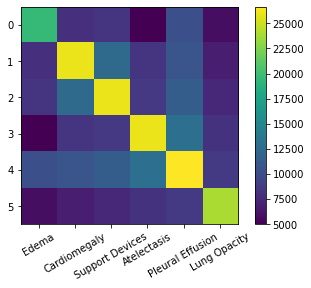

In [ ]:
#np.fill_diagonal(co_occurrence_matrix,0)
tick_labels = columns[3:]
print(co_occurrence_matrix)

# create the plot
fig, ax = plt.subplots()

# set the xticks and labels
#ax.set_xticks(label_subset)
ax.set_xticklabels(tick_labels, rotation=30, ha='center')
# display array as matrix
plt.imshow(co_occurrence_matrix, cmap='viridis')
plt.colorbar()
# show the plot
plt.show()

## Co-occurence graphs

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#df = pd.read_csv(r"random_sample.csv")
df = random_df

In [ ]:
df.loc[:, label_subset] = df.loc[:, label_subset].applymap(lambda x: np.nan if x <= 0 else x)

[26000.  8252.  8147.  4997. 12879.  8592.]
[ 8252. 26000.  6812.  7985. 10721. 12469.]
[ 8147.  6812. 23899.  5783.  8658.  7442.]
[ 4997.  7985.  5783. 19500. 10280.  8269.]
[12879. 10721.  8658. 10280. 26638. 11346.]
[ 8592. 12469.  7442.  8269. 11346. 26000.]


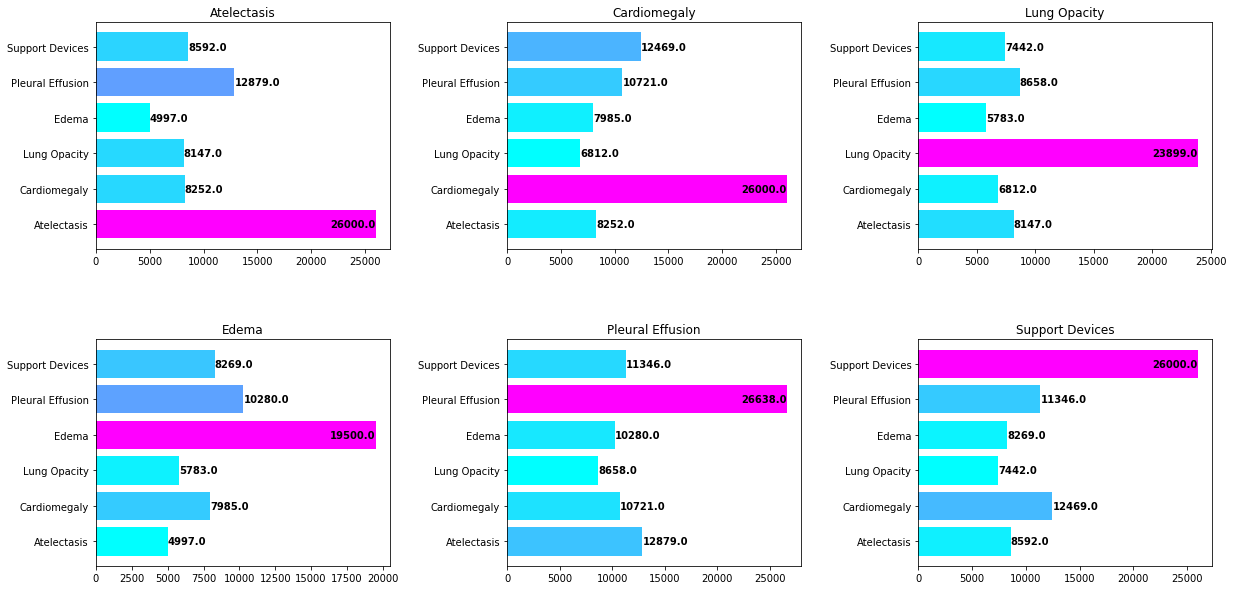

In [ ]:
# vielleicht kannst du den Output noch sortieren nach der höchsten Anzahl an gemeinsamen labels
comp_2_rest = False
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
n_diseases = len(diseases_incl)
n_subplots = len(axs.flat)

for i, label in enumerate(diseases_incl):
    row = i // 3
    col = i % 3
    ax = axs[row][col]
    ticks = []
    position = 0
    if comp_2_rest:
        diseases_excl_loop = diseases_excl_orig[0:8]
        diseases_excl_loop.append(label)
        diseases = df.loc[:,diseases_excl_loop]
        ticks = diseases_excl_loop
        ticks[1] = 'Enlarged\nCardiomediastinum'
        position = len(diseases_excl_orig)
    else:
        diseases = df.loc[:,diseases_incl]
        ticks = diseases_incl
        position = i
        
    diseases[np.isnan(diseases)] = 0
    co_occurrence_matrix = np.dot(diseases.T, diseases)
    # Define your array of values
    values = np.array(co_occurrence_matrix[position])

    print(values)

    # Define your colormap
    cmap = plt.get_cmap('cool')

    # Normalize your values to the range [0, 1]
    norm = plt.Normalize(values.min(), values.max())

    # Map your values to colors using the colormap and the normalization
    colors = cmap(norm(values))

    if values.any():
        # Display your colors as a horizontal bar chart
        ax.barh(range(len(values)), values, color=colors)

        ax.set_yticks(range(len(values)))  # set tick positions
        ax.set_yticklabels(ticks)  # set tick labels
        ax.set_title(label)
        for j, val in enumerate(values):
            if val < 15000 :
                ax.text(val, j, str(val), color='black', fontweight='bold', ha='left', va='center')
            elif val > 0:
                ax.text(val, j, str(val), color='black', fontweight='bold', ha='right', va='center')
    else:
        ax[3][2].axis("off") 
        fig.delaxes(ax[3][2])
    # remove empty subplots
    #if i >= n_subplots:
    #    fig.delaxes(ax[3][2])
        
# adjust spacing between subplots
plt.subplots_adjust(wspace=0.4, hspace=0.4)

plt.show()

In [ ]:
atelectasis_csv = pd.read_csv('atelectasis_comparison.csv', sep=';')
atelectasis_csv = atelectasis_csv[['dicom_id', 'Atelectasis']]
atelectasis_df = data_subset[['dicom_id', 'Atelectasis']]
atelectasis_df = atelectasis_df[atelectasis_df['Atelectasis'] == 1]

In [ ]:
merged_df = pd.merge(atelectasis_df, atelectasis_csv, how='outer', indicator=True)
not_in_df2 = merged_df[merged_df['_merge'] == 'left_only']
not_in_df2

,dicom_id,Atelectasis,_merge
0,3813b9b6-88d998b4-941e767b-601ba7c1-98f61102,1.0,left_only
2,85a5f9ac-6a7c30f8-a7a94492-5726acf2-d0b87401,1.0,left_only
3,351fd417-c131e1fd-6573229f-5e58f4cf-a15263a6,1.0,left_only
4,4405b529-d230819d-096d8a07-d3e9749a-f78c09c0,1.0,left_only
6,72d55d23-84921ec6-99e95337-aeccd52a-50da54bb,1.0,left_only
...,...,...,...
48777,b32ca787-236dfe04-25ad4267-18bcda62-d18a8f31,1.0,left_only
48779,6866acaf-1c822e0e-8ac3ad8d-fa0f208e-3e33c589,1.0,left_only
48780,32fb7803-7dc89bb6-30e5a4e0-09c09ff6-f84863ab,1.0,left_only
48781,af2fb6e4-eef63da9-988c750f-5a703add-e655ef75,1.0,left_only


# Backup

In [ ]:
        if num_lists_fem > 0 and len(list_female) <= num_lists_fem:
            selected_lists_fem = list_female
        else:
            selected_lists_fem = random.sample(list_female, num_lists_fem)
        if num_lists_male > 0 and len(list_male) <= num_lists_male:
            selected_lists_male = list_male
        else:
            selected_lists_male = random.sample(list_male, num_lists_male)

In [ ]:
array_list = {
    'Atelectasis': 0,
    'Cardiomegaly': 0,
    'Consolidation': 0,
    'Edema': 0,
    'Enlarged Cardiomediastinum': 0,
    'Lung Lesion': 0,
    'Lung Opacity': 0,
    'No Finding': 0,
    'Pleural Effusion': 0,
    'Pleural Other': 0,
    'Pneumonia': 0,
    'Pneumothorax': 0,
    'Support Devices': 0
}

In [ ]:
# get a boolean DataFrame indicating which elements are nonzero
nonzero_df = count_subjects_df[labels] > 0

# use the boolean DataFrame to get the labels of the nonzero elements for each row
results = nonzero_df.apply(lambda row: row.index[row].tolist(), axis=1)

In [ ]:
df = count_subjects_df[labels]
results = []
for row_index in range(len(count_subjects_df)): #
    # nimm dir eine Zeile und erhalte alle Spalten, die größer null sind
    result = df.iloc[row_index][df.iloc[row_index] > 0].index.tolist()
    for item in result:
        # in einem 2D Array, das die Labels enthält, addiere +1 in diesem Bucket
        array_list[item] += 1



KeyError: 'Fracture'

In [ ]:
print(array_list)

{'Atelectasis': 0, 'Cardiomegaly': 0, 'Consolidation': 0, 'Edema': 0, 'Enlarged Cardiomediastinum': 0, 'Lung Lesion': 0, 'Lung Opacity': 0, 'No Finding': 0, 'Pleural Effusion': 0, 'Pleural Other': 0, 'Pneumonia': 0, 'Pneumothorax': 0, 'Support Devices': 0}


In [ ]:
import numpy as np
labels = ['Atelectasis','Cardiomegaly','Consolidation','Edema','Enlarged Cardiomediastinum','Lung Lesion','Lung Opacity','No Finding','Pleural Effusion','Pleural Other','Pneumonia','Pneumothorax','Support Devices']

In [ ]:
import numpy as np
import pandas as pd

train_size = 1000
test_size = 200
columns = 30

## create train data
y_train = np.random.choice([0,1,2,3], train_size, p=[0.15, 0.35, 0.28, 0.22])
x_train = pd.DataFrame(np.random.uniform(0,1, (train_size,columns)))

## create test data
y_test = np.random.choice([0,1,2,3], test_size, p=[0.15, 0.35, 0.28, 0.22])
x_test = pd.DataFrame(np.random.uniform(0,1,(test_size,columns)))

In [ ]:
import random

array_of_lists = [[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]]

# select random percentage of lists
percentage = 50
num_lists = int(len(array_of_lists) * (percentage / 100))
selected_lists = random.sample(array_of_lists, num_lists)

print(selected_lists)

[[4, 5, 6], [10, 11, 12]]


In [ ]:
import pandas as pd

my_list = [[1, 'a'], [2, 'b', 'c'], [3, 'd', 'e', 'f']]

df = pd.DataFrame(data=my_list)

print(df)

   0  1     2     3
0  1  a  None  None
1  2  b     c  None
2  3  d     e     f


In [ ]:
import itertools
from collections import Counter

numbers = [1, 3, 5, 10, 20, 40]

# Generate all combinations of the numbers
combinations = []
for r in range(1, len(numbers) + 1):
    combinations.extend(list(itertools.combinations(numbers, r)))

# Calculate the sum of each combination
sums = [sum(combination) for combination in combinations]

# Count the frequencies of each total
frequency_counter = Counter(sums)

# Create an array to store the frequencies
buckets = [0] * (max(frequency_counter.keys()) + 1)

# Store the frequencies in the array
for total, frequency in frequency_counter.items():
    buckets[total] = frequency

# Print the totals, frequencies, and corresponding combinations
for total, frequency in enumerate(buckets):
    #print(f"Total: {total}, Frequency: {frequency}")
    #print("Combinations:")
    for combination in combinations:
        if sum(combination) == total:
            #print(combination)
            print()

In [ ]:
def det_num_samples_gender(dataset, size_reduction):
    
    num_fem_samples = dataset.loc[dataset['gender'] == 'F'].value_counts().size

    
    # Determine the number of samples to remove
    removal_count = int(len(dataset) * size_reduction)
    
    female_ratio = num_fem_samples / len(dataset)
    
    # Calculate the desired number of removed samples for each gender
    male_removals = int(removal_count * (1- female_ratio))
    female_removals = int(removal_count * female_ratio)
    removals = {'M':male_removals,'F':female_removals}
    return removals

det_num_samples_gender(data_subset, 0.1)